# **Filtering 2D**

<div style="color:#777777;margin-top: -15px;">
<b>Author</b>: Norman Juchler |
<b>Course</b>: ADLS ISP |
<b>Version</b>: v1.2 <br><br>
<!-- v1.2, 12.04.2025: Refactored text -->
</div>

In this notebook, we will explore image filtering in both the spatial and frequency domains. We will also examine the concept of convolution and its role in image processing.

<!--
## **Exercises**
* [Exercise 1: Spectral filtering](#exercise1)  
* [Exercise 2: Interpretation of spectra](#exercise2)  
* [Exercise 3: Spatial filtering with kernels](#exercise3)  
* [Exercise 4: Edge detection](#exercise4)  
* [Exercise 5: Border handling](#exercise5)
-->


---

## **Preparations**

The usual preparations... Before we begin, let's load some drawing functions for rendering images effortlessly in this Jupyter notebook.

In [1]:
import sys
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft
import scipy.signal

# Enable vectorized output (for nicer plots)
%config InlineBackend.figure_formats = ["svg"]

# Inline backend configuration
%matplotlib inline

# Functionality related to this course
sys.path.append("..")
import isp

# Jupyter / IPython configuration:
# Automatically reload modules when modified
%load_ext autoreload
%autoreload 2

---

<a id='exercise1'></a>

## **☆ Exercise 1: Spectral filtering**

The photo *"moon-walk.jpg"* shows astronaut Harrison Schmitt walking on the Moon during the Apollo 17 mission in 1972. This image has been artificially distorted with periodic noise. If you're curious, the code used to generate the distortion is provided below in the *Supplemental Material* section. The goal of this exercise is to remove the distortion using spectral filtering.

Such regular, periodic distortions were common in the early days of digital printing, particularly when using the [halftone technique](https://en.wikipedia.org/wiki/Halftone). This method simulates continuous-tone imagery (i.e., images with smooth intensity gradients) by varying the size or spacing of dots, which can introduce visible, repetitive patterns in printed images.





Original: moon-walk.jpg                   |  moon-walk-distorted-w2.5.jpg         | moon-walk-distorted-w5.jpg 
:-------------------------:|:-------------------------:|:-------------------------:
![](../data/images/moon-walk-square.jpg)  | ![](../data/images/moon-walk-distorted-w2.5.jpg)  |  ![](../data/images/moon-walk-distorted-w5.jpg) | 




### **Instructions**

1. Load the images "moon-walk-distorted-w5.jpg" and "moon-walk-distorted-w2.5.jpg" from the folder "../data/images/" and display them.
2. Compute the Fourier transform of the images and display both the magnitude and phase.
3. From the subfolder "../data/images/moon-walk-masks/", load and test different filter masks for spectral filtering.
4. Apply the masks to the Fourier transform to suppress the frequency components responsible for the noise.
5. Compute the inverse Fourier transform to reconstruct the filtered image.
6. Repeat the process using different masks and for other distortion levels (e.g., w5, w7.5).
7. Discuss your results and reflect on the effectiveness of the filtering.

**Note:** Using the code provided in the *Supplemental Material* section below, you can generate distorted images with varying levels of distortion. The parameter `w` defines the *spatial period* (i.e., the wavelength in pixels) of the distortion pattern. For example, the image `moon-walk-distorted-w5.jpg` was distorted using a pattern with a spatial period of `w = 5`.


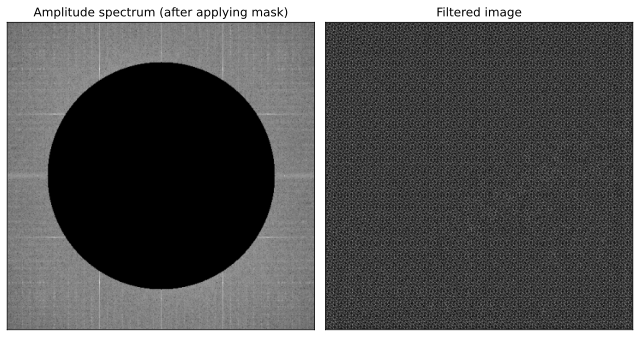

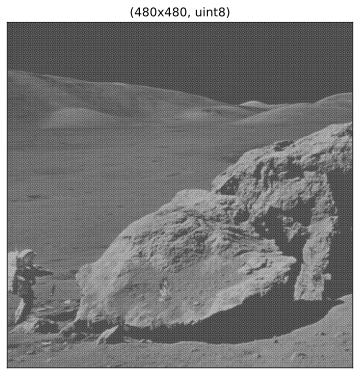

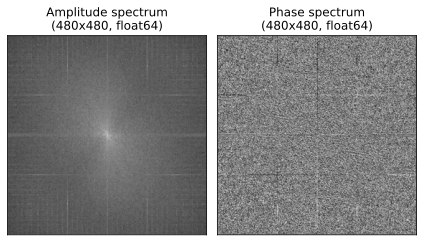

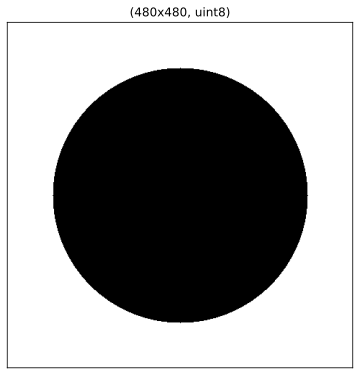

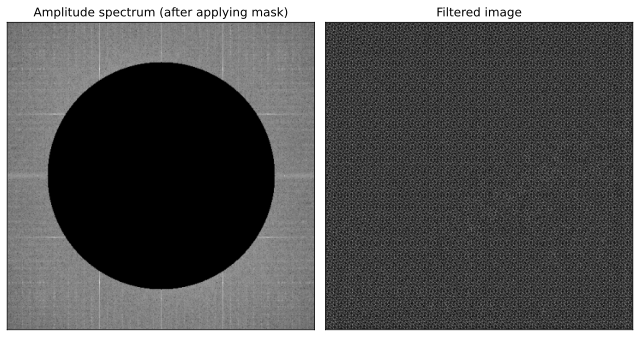

In [2]:
######################
###    EXERCISE    ###
######################

# 1) Load the image "moon-walk-distorted-w2.5.jpg" and display it.
#    (...or moon-walk-distorted-w5.jpg, or moon-walk-distorted-w7.5.jpg)
img = cv.imread('../data/images/moon-walk-distorted-w2.5.jpg',cv.IMREAD_GRAYSCALE)
isp.show_image(img)
                
# 2) Compute the Fourier transform and display the magnitude / phase.
ft = scipy.fft.fft2(img)
ft = scipy.fft.fftshift(ft)
ft_amp = np.log(np.abs(ft)+1)
ft_phase = np.angle(ft)



isp.show_image_pair(ft_amp, ft_phase, 
                    title1="Amplitude spectrum", 
                    title2="Phase spectrum", 
                    normalize=True)

# 3) Load a filter mask of the subfolder ../data/images/moon-walk-masks/
mask = cv.imread('../data/images/moon-walk-masks/mask2-w2.5.png',cv.IMREAD_GRAYSCALE)
isp.show_image(mask)
# 4) Apply the mask to the Fourier transform
ft_filt = ft*mask
ft_amp_filt = ft_amp*mask
        
# 5) Compute the inverse Fourier transform and display the result
ft_filt = scipy.fft.ifftshift(ft_filt)
image_rec = np.abs(scipy.fft.ifft2(ft_filt))
image_rec = (image_rec - image_rec.min()) / (image_rec.max() - image_rec.min()) * 255
        
# Display the result
isp.show_image_grid([ft_amp_filt, image_rec],
titles=["Amplitude spectrum (after applying mask)", "Filtered image"],
suppress_info=True,
ncols=2)



### **Observations:**

* The **low-pass filter**  (mask 1) removes high-frequency components, resulting in a blurred image. While the artifacts are reduced, the image appears less sharp.
* The **high-pass filter** (mask 2) removes low-frequency content but retains the artifacts. It also largely attenuates the main image content, making it ineffective for this task.
* The **selective-pass** and **band-pass filters** (masks 3–8) attenuate frequency components associated with the distortion pattern. These filters effectively reduce artifacts while preserving the main image content.
* The **selective-pass filters** tend to be less aggressive than band-pass filters, which can lead to a more natural visual appearance.
* As discussed in the context of 1D signals, ideal (sharp) spectral filters can introduce unwanted artifacts in the spatial domain. Filters with smoother transitions between passband and stopband – such as linear or Gaussian masks – help mitigate these effects and produce more natural-looking results.
* Filtering is less effective near the image borders due to the **periodic assumption** of the Fourier transform, which treats the image as if it repeats infinitely in all directions.



---

### ***Supplemental Materials: Code to Generate Distorted Images and Filter Masks***

**<u>Feel free to skip this section if you're not interested in the implementation details.</u> 🙂**

The distorted images were generated using the code below. You can use it to create your own distorted versions. The distortion is based on the superposition of multiple gratings at different orientations. Key parameters include the *wavelength* of the gratings (in pixels) and the *angular step size* that defines their orientation. For this exercise, distortions were generated using wavelengths of 2.5, 5.0, and 7.5 pixels.


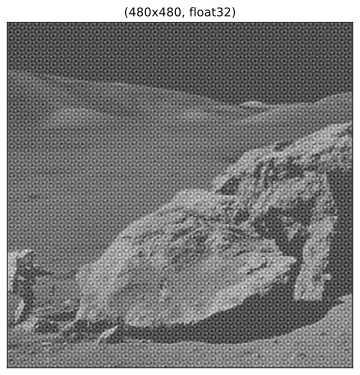

In [3]:
def sinusoidal_grating_dir(shape, A, l, phi=0, angle=0, offset=0):
    """This is the sinusoidal grating function that we already have implemented
    in the previous notebook. It generates a sinusoidal grating image with the
    specified parameters.
    """
    i = np.arange(shape[1])
    j = np.arange(shape[0])
    X, Y = np.meshgrid(i, j)
    angle = np.deg2rad(angle)
    img = A * np.sin(2 * np.pi / l * ((X*np.cos(angle) + Y*np.sin(angle))) + phi) + offset
    return img.astype(np.float32)


def add_periodic_pattern(image, wavelength, step, alpha=0.6):
    # Convert to floating point and normalize
    if image.dtype == np.uint8:
        image = image.astype(np.float32)
        image /= 255

    # Add distortion: sinusoidal gratings a different orientations:
    #    angles = [0, 30, 60, 90, 120, 150]
    # Note: We only need angles from 0 to 180, since the gratings are symmetric.
    #       The gratings at 0 and 180 degrees are mirrored, and will cancel each 
    #       other out.

    # Parameters for the sinusoidal gratings
    amplitude = 1
    phase = 0
    angles = np.arange(0, 180, step)
    # Create a list of gratings
    gratings = [sinusoidal_grating_dir(shape=(image.shape), 
                                       A=amplitude, 
                                       l=wavelength, 
                                       phi=phase, 
                                       angle=angle, 
                                       offset=0) for angle in angles]
    # Sum the list of images element-wise (using numpy)
    gratings = np.sum(gratings, axis=0)
    # Normalize (floating point image, values between 0 and 1)
    gratings = (gratings - gratings.min()) / (gratings.max() - gratings.min())
    # Mix the gratings with the original image
    image = (1-alpha)*image + alpha*gratings
    return image


# Parameters for the sinusoidal gratings:
wavelength = 5    # Wavelegth of the grating (in pixels, here: 2.5, 5, 7.5)
step = 30         # Step size for the angles (in degrees)

# Load the image
image = cv.imread("../data/images/moon-walk-square.jpg", cv.IMREAD_GRAYSCALE)
image = add_periodic_pattern(image, wavelength, step)
isp.show_image(image, normalize=True);

# cv.imwrite("../data/images/moon-walk-distorted-w%g.jpg" % wavelength, 
#            image*255, [int(cv.IMWRITE_JPEG_QUALITY), 90]);

<!-- 
Development note: 

```python
# Force the input image to have a suitable size in order to avoid edge 
# effects when calculating the DFT/IDFT. See this post for details:
# https://dsp.stackexchange.com/questions/93712/
h = cv.getOptimalDFTSize(image.shape[0])
w = cv.getOptimalDFTSize(image.shape[1])
mt = (w - image.shape[1]) // 2
mb = (w - image.shape[1] - mt)
ml = (h - image.shape[0]) // 2
mr = (h - image.shape[0] - ml)
image = cv.copyMakeBorder(image, mt, mb, ml, mr, cv.BORDER_REFLECT)
cv.imwrite("../data/images/moon-walk-square-fixed.jpg", 
           image, [int(cv.IMWRITE_JPEG_QUALITY), 90]);
```
-->

Create the different masks. The mask geometries depend on the wavelength (and the angle step) of the periodic distortion created above.

In [ ]:
def circular_mask_pattern(image, wavelength, step, size):
    """Function that creates a mask with small circles along a bigger circle. 
    The circle radii are determined by the wavelength parameter."""
    mask = np.zeros_like(image)
    radius = image.shape[0]/wavelength
    angles = np.arange(0, 360, step)
    for a in angles:
        x = int(image.shape[1]/2 + radius*np.cos(np.deg2rad(a)))
        y = int(image.shape[0]/2 + radius*np.sin(np.deg2rad(a)))
        mask = cv.circle(mask, (x, y), size, 1, -1)
    mask = 1-mask
    return mask

# Ensure output folder
isp.ensure_dir("../data/images/moon-walk-masks/")

# Used for the ring masks
J, I = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
R = np.sqrt((J - image.shape[1]//2)**2 + (I - image.shape[0]//2)**2)

# Mask 1: Low-pass filter
margin = 15
mask_low = np.zeros_like(image, dtype=np.uint8)
mask_low[R < (image.shape[0]/wavelength-margin)] = 1
cv.imwrite("../data/images/moon-walk-masks/mask1-w%g.png" % wavelength, 
           (mask_low*255).astype(np.uint8))

# Mask 2: High-pass filter
mask_high = np.zeros_like(image, dtype=np.uint8)
mask_high[R > (image.shape[0]/wavelength-margin)] = 1
cv.imwrite("../data/images/moon-walk-masks/mask2-w%g.png" % wavelength, 
           (mask_high*255).astype(np.uint8))

# Mask 3: Circular mask
size = 9
mask = circular_mask_pattern(image, wavelength, step, size=size)
mask_circ_hs = mask.copy()
cv.imwrite("../data/images/moon-walk-masks/mask3-w%g.png" % wavelength, 
           (mask_circ_hs*255).astype(np.uint8))

# Mask 4: Linearly weighted circular mask
# Apply distance transform to the circular mask
mask = circular_mask_pattern(image, wavelength, step, size=size*2)
dist = cv.distanceTransform(1-mask.astype(np.uint8), cv.DIST_L2, cv.DIST_MASK_PRECISE)
mask_circ_lin = (1-dist/np.max(dist))
cv.imwrite("../data/images/moon-walk-masks/mask4-w%g.png" % wavelength, 
           (mask_circ_lin*255).astype(np.uint8))

# Mask 5: Gaussian weighted circular mask
# Distance --> Gaussian values
dist = np.exp(-dist**2/(size**2))
mask = dist/np.max(dist)
mask_circ_gauss = (mask-mask.min())/(np.max(mask)-mask.min())
cv.imwrite("../data/images/moon-walk-masks/mask5-w%g.png" % wavelength, 
           (mask_circ_gauss*255).astype(np.uint8))

# Mask 6: Ring mask
radius = image.shape[0]/wavelength
dist = np.abs(R - radius)
mask_ring_hs = dist>size
cv.imwrite("../data/images/moon-walk-masks/mask6-w%g.png" % wavelength,
           (mask_ring_hs*255).astype(np.uint8))

# Mask 7: Linearly weighted ring mask
dist = np.clip(dist, 0, size)
mask_ring_lin = dist.astype(float) / size
cv.imwrite("../data/images/moon-walk-masks/mask7-w%g.png" % wavelength, 
           (mask_ring_lin*255).astype(np.uint8))

# Mask 8: Gaussian weighted ring mask
mask = np.exp(-dist**2/(size**2))
mask = (mask-mask.min())/(np.max(mask)-mask.min())
mask_ring_gauss = (1-mask)
cv.imwrite("../data/images/moon-walk-masks/mask8-w%g.png" % wavelength, 
           (mask_ring_gauss*255).astype(np.uint8))

# Test mask, pick one of the above masks:
#   - mask_low
#   - mask_high
#   - mask_circ_hs
#   - mask_circ_lin
#   - mask_circ_gauss
#   - mask_ring_hs
#   - mask_ring_lin
#   - mask_ring_gauss
mask = mask_ring_gauss
ft = scipy.fft.fft2(image)
ft = scipy.fft.fftshift(ft)
ft_amp = np.log(np.abs(ft))
ft_amp *= mask
isp.show_image_pair(mask, ft_amp, 
                    title1="Mask", 
                    title2="Amplitude spectrum", 
                    figsize=(9, 5),
                    normalize=True);

---

<a id='exercise2'></a>

## **☆ Exercise 2: Interpretation of spectra**

Take a look at the amplitude spectrum of the image below, which displays a honeycomb pattern.

![Honeycomb](../data/images/honeycomb1.jpg)


### **Instructions**

Recall that the Fourier transform is generally complex-valued. This means that each element in the Fourier transform (an NxM array) is a complex number, which can be uniquely described by its magnitude $|z|$ and phase $\varphi = \arg(z)$: $\quad z = |z| e^{i\varphi} $

1. Load the image honeycomb1.jpg (or honeycomb2.jpg) in grayscale.
2. Compute and visualize the amplitude and phase spectra.
3. Answer: What information can you extract from the amplitude and phase spectra of the image?
4. Reconstruct the image from its Fourier transform by:
   * Setting the amplitude to 1 (i.e., keep only the phase information, using a constant amplitude)
   * Setting the phase to 0 (i.e., keep only the amplitude, remove phase information)
5. Reflect: What can you infer from these reconstructions?


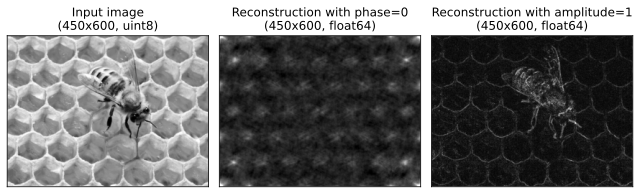

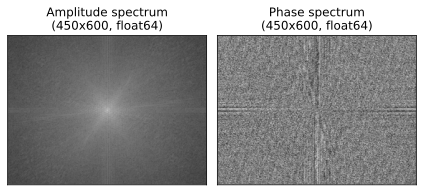

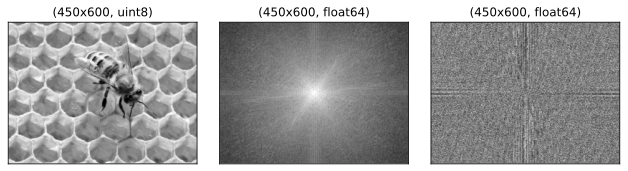

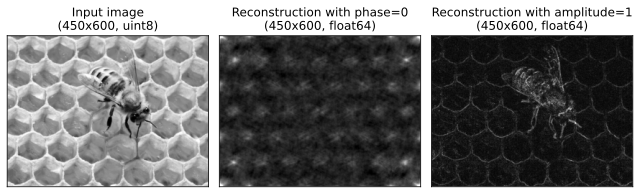

In [3]:
######################
###    EXERCISE    ###
######################

# 1) Load the honeycomb image "honeycomb1.jpg" (or "honeycomb2.jpg") 
image = cv.imread('../data/images/honeycomb2.jpg',cv.IMREAD_GRAYSCALE)

# 2) Display the image and its Fourier transform (magnitude and phase)
ft = scipy.fft.fft2(image)
ft = scipy.fft.fftshift(ft)
ft_amp = np.log(np.abs(ft)+1)
ft_phase = np.angle(ft)

isp.show_image_pair(ft_amp, ft_phase, 
                    title1="Amplitude spectrum", 
                    title2="Phase spectrum", 
                    normalize=True)


# Display the spectra using our convenience function isp.show_image()
# (The argument "normalize stretch" is used to enhance the spectrum of the 
# spectra to see more structure). Alternatively, just use normalize=True
isp.show_image_chain([image, ft_amp, ft_phase], normalize_stretch=0.1)

# 3) Question: What can be seen in the Fourier transform?
#In the Fourier transform of the image, the amplitude spectrum clearly shows a 
# bright central region representing low frequencies, along with regular patterns that indicate
#  the periodic structure of the honeycomb. The phase spectrum appears more random at first glance but 
# contains the fine details and edge information essential for reconstructing the original image.

# Phase = 0: 
#  --> ft_amp = r*exp(i*0) = r 
#  --> apply inverse FT
ft_amp = np.abs(ft)
ft_amp = scipy.fft.ifftshift(ft_amp)
# The inverse Fourier transform should be real valued, but due
# to numerical errors, we need to take the absolute value.
image_rec_amp = np.abs(scipy.fft.ifft2(ft_amp))

# Amplitude = 1:
#  --> ft_phase = 1*exp(i*phi) = exp(i*phi)
#  --> apply inverse FT
ft_phase = np.exp((0+1j)*ft_phase)
ft_phase = scipy.fft.ifftshift(ft_phase)
# The inverse Fourier transform should be real valued, but due
# to numerical errors, we need to take the absolute value.
image_phase_rec = np.abs(scipy.fft.ifft2(ft_phase))

# Visualize
isp.show_image_chain([image, image_rec_amp, image_phase_rec], 
                     titles=["Input image", 
                             "Reconstruction with phase=0", 
                             "Reconstruction with amplitude=1"],
                     normalize_stretch=0.1)




**Observations**

- The honeycomb pattern is clearly visible in the amplitude spectrum: three bright axes appear, corresponding to the main directions of the hexagonal structure. In contrast, the phase spectrum does not reveal any obvious structure.
- The amplitude spectrum encodes the intensity distribution of frequency components, but on its own it is not sufficient to reconstruct the image. Without phase information, the overall shape and structure are lost.
- The phase spectrum carries the essential information about the position and shape of structures in the image. Even though most intensity information is missing, the objects remain clearly recognizable.


---

<a id='exercise3'></a>

## **☆ Exercise 3: Spatial filtering with kernels**

In this exercise, you'll explore how different filter kernels affect an image. Feel free to experiment by designing your own kernels and observing the results!

**Note:** Kernels must have an odd number of rows and columns so that the center of the kernel aligns with a specific pixel.
- (Kernels must have an odd number of rows and columns so that there is a clear center pixel, which allows the kernel to be symmetrically applied around a target pixel during convolution. This ensures that the operation is properly aligned and the filter’s effect is centered exactly on each pixel in the image.)

### **Instructions**
* Check out the following resources for examples of commonly used kernels:
  * [Wikipedia: Image processing kernels](https://en.wikipedia.org/wiki/Kernel_(image_processing))
  * [setosa.io: Interactive kernel visualizations](https://setosa.io/ev/image-kernels/)
* Choose a few kernels and implement them in Python.
* Apply the kernels to the image `"camera.png"` using one of the following methods:
  * OpenCV: [cv.filter2D()](https://docs.opencv.org/3.4/d4/dbd/tutorial_filter_2d.html)
  * SciPy: [scipy.signal.convolve2d()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html)

Remember that applying a filter is equivalent to convolving an image with a kernel. As discussed in the lecture, performing convolution via the Fourier domain can be more efficient—particularly for large kernels. However, for small kernels (typically size < 11), direct convolution is usually faster. Functions like `cv.filter2D()` and `convolve2d()` automatically choose the appropriate method.


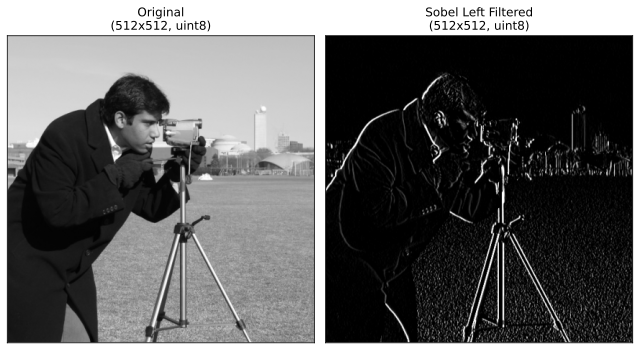

In [4]:
######################
###    EXERCISE    ###
######################


# Load grayscale image
image = cv.imread("../data/images/camera.jpg", cv.IMREAD_GRAYSCALE)

# Define a single kernel (Sobel left as example)
kernel = np.array([[1,  0, -1],
                   [2,  0, -2],
                   [1,  0, -1]])

# Apply the filter using OpenCV
dtype_out = cv.CV_8U  # or -1
image_filtered = cv.filter2D(image, dtype_out, kernel)

# Optional: Convert to abs + clip if you used CV_32F


# Display original and filtered image
isp.show_image_pair(image, image_filtered,
                    title1="Original",
                    title2="Sobel Left Filtered",
                    figsize=(9, 5))


---

<a id='exercise4'></a>

## **☆ Exercise 4: Edge detection**

In the previous exercise, we saw that certain kernels can be used to enhance edges in an image. These kernels approximate the derivative of the image. Common examples include the Sobel and Prewitt filters. Another widely used edge detector is the Laplacian filter.

Note: Computing the derivative of an image is sensitive to noise amplification. (Can you explain why?)
To reduce the effect of noise, it is good practice to smooth the image before computing its derivative.

Edge detection is a two-step process:
1. **Enhance the edges** by transforming the image (e.g., using a gradient or Laplacian filter).
2. **Detect the edges** by applying a thresholding technique to produce a binary edge mask.

In this exercise, we want to implement such an edge detection algorithm.

### **Instructions**
1. Load the image in grayscale.
2. Smooth the image using cv.GaussianBlur().
3. Choose a suitable edge-enhancing kernel.
4. Apply thresholding to generate a binary mask that highlights the edges.


***Please Checkout the Solution of the Professor for the exam***

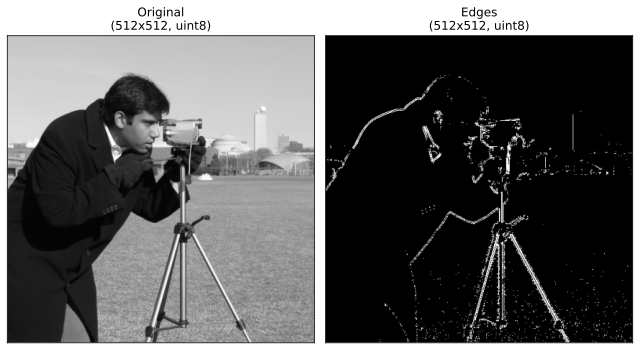

In [16]:
######################
###    EXERCISE    ###
######################

# 1) Load the image "camera.jpg" and display it.
image_1 = cv.imread('../data/images/camera.jpg',cv.IMREAD_GRAYSCALE)

# 2) Smooth the image using cv.GaussianBlur()
image_smoothed = cv.GaussianBlur(image_1,(3,3),0)

# 3) + 4) Implement your edge detection method
edges = cv.convertScaleAbs(cv.Laplacian(image_smoothed, cv.CV_64F))

#thresholding to generate binary mask
_, edges_binary = cv.threshold(edges, 30, 255, cv.THRESH_BINARY)



# Visualization:
isp.show_image_pair(image_1, edges_binary, 
                    title1="Original", 
                    title2="Edges", 
                    figsize=(9, 5))

---

<a id='exercise5'></a>

## **☆ Exercise 5: Border handling**

In both spectral filtering (e.g., in Exercise 1) and spatial filtering (e.g., convolution with a kernel), proper handling of image borders is essential to avoid unwanted artifacts. This section briefly illustrates how OpenCV provides convenient ways to manage image edges.

In spectral filtering, artifacts often arise due to discontinuities at the image borders, especially since the Discrete Fourier Transform (DFT) assumes the image is periodic. One effective way to suppress these artifacts is to extend the image using mirrored or repeated borders.

OpenCV functions such as [`cv.filter2D()`](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga27c049795ce870216ddfb366086b5a04)   support an optional `borderType` parameter, which specifies how to handle the borders. The default is `cv.BORDER_DEFAULT`, which reflects (mirrors) the border pixels. See the full list of available options [here](https://docs.opencv.org/4.x/d2/de8/group__core__array.html#ga209f2f4869e304c82d07739337eae7c5).

### **Instructions**
* Load an arbitrary image
* Illustrate the different border types

In [ ]:
######################
###    EXERCISE    ###
######################
...